# Final charts


In [13]:
import numpy as np
import torch
from typing import Literal
from safetensors import safe_open
from safetensors.torch import load_file
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import wandb
import warnings
sys.path.append("../")
from jacobian_saes.utils import load_pretrained, run_sandwich


In [14]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


## Jacobian sparsity
Run `runners/histogram.py` first to get the data

We also plot the cumulative density function because it lets us see the differences more easily

In [15]:
model = "pythia-70m-deduped"
layer = 3

def get_hist_path(model: str, layer: int, trained_with_jac: bool = True):
    return f"../results/histograms/sae_pair_{model}_layer{layer}_16384_J{1 if trained_with_jac else 0.0}_k32:v0.safetensor"

with safe_open(get_hist_path(model, layer, True), framework="pt") as f:
    hist = f.get_tensor("hist")
    bin_edges = f.get_tensor("bin_edges")
    n_tokens_in_hist = int(float(f.metadata()["tokens"]))

bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
hist_no_optim = load_file(get_hist_path(model, layer, False))["hist"]


In [16]:
upper_zoom_thresh = 0.1
cropped_bin_centers = bin_centers[bin_centers < upper_zoom_thresh]
cropped_hist = hist[bin_centers < upper_zoom_thresh]
cropped_hist_no_optim = hist_no_optim[bin_centers < upper_zoom_thresh]

cdf = hist.cumsum(dim=0) / hist.sum()
cdf_no_optim = hist_no_optim.cumsum(dim=0) / hist_no_optim.sum()


In [17]:
thresholds = [0.005, 0.01, 0.015, 0.02]
num_above_thresholds = []
num_above_thresholds_no_optim = []
for thresh in thresholds:
    # find the index of the bin edge that is equal to the threshold (assume it will always be there)
    idx = torch.where((bin_edges - thresh).abs() < 1e-6)[0].item()
    num_above_thresholds.append(hist[idx:].sum().item() / n_tokens_in_hist)
    num_above_thresholds_no_optim.append(hist_no_optim[idx:].sum().item() / n_tokens_in_hist)
num_above_thresholds, num_above_thresholds_no_optim

([233.8166784, 115.6935168, 72.3455168, 49.8944672],
 [854.8892672, 704.6360576, 581.183488, 482.4617984])

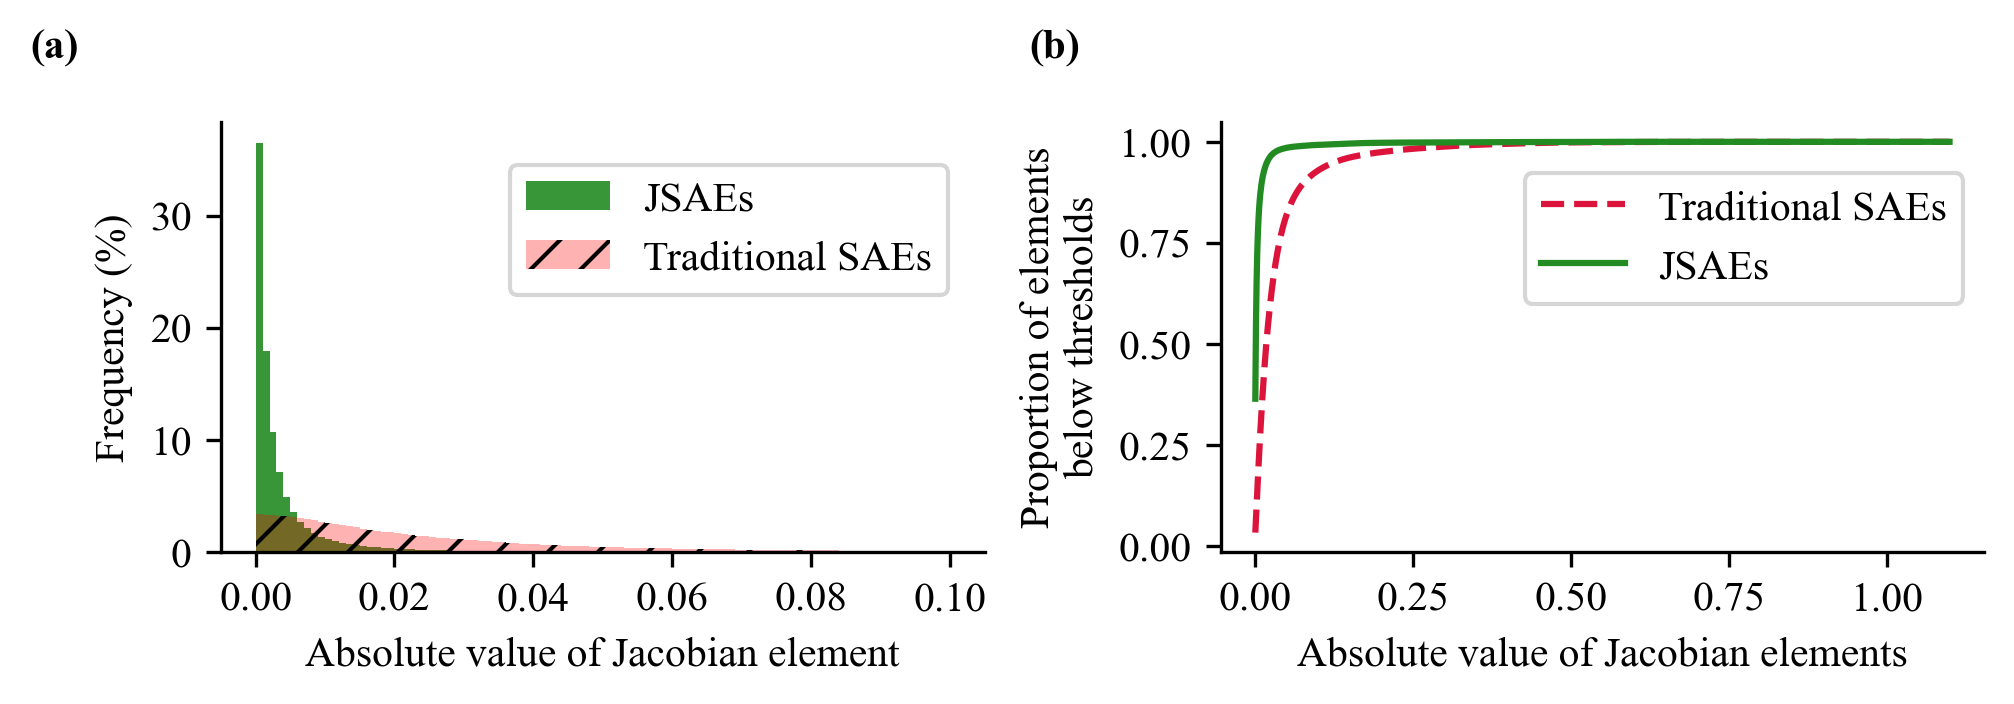

In [18]:
# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.75, 2.5), dpi=300)

# First subplot (histogram)
width = (bin_edges[1] - bin_edges[0]).item()
ax1.bar(cropped_bin_centers.cpu().numpy(), 
       cropped_hist.cpu().numpy() / hist.sum().item() * 100,
       width=width,
       color='forestgreen',
       alpha=0.9,
       label='JSAEs')
ax1.bar(cropped_bin_centers.cpu().numpy(),
       cropped_hist_no_optim.cpu().numpy() / hist_no_optim.sum().item() * 100,
       width=width,
       color='red',
       alpha=0.3,
       hatch='//',
       label='Traditional SAEs')
ax1.set_xlabel('Absolute value of Jacobian element')
ax1.set_ylabel('Frequency (%)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper right', bbox_to_anchor=(0.98, 0.95), fancybox=True)

# Second subplot (CDF)
ax2.plot(bin_centers.cpu().numpy(), 
       cdf_no_optim.cpu().numpy(),
       color='crimson',
       linestyle='--',
       label='Traditional SAEs')
ax2.plot(bin_centers.cpu().numpy(),
       cdf.cpu().numpy(),
       color='forestgreen',
       linestyle='-',
       label='JSAEs')
ax2.set_xlabel('Absolute value of Jacobian elements')
ax2.set_ylabel('Proportion of elements\nbelow thresholds')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.93), fancybox=True)

# Add subplot labels (a) and (b)
ax1.text(-0.25, 1.15, '(a)', transform=ax1.transAxes, fontsize=10, fontweight='bold')
ax2.text(-0.25, 1.15, '(b)', transform=ax2.transAxes, fontsize=10, fontweight='bold')

# Adjust layout
plt.tight_layout(pad=1.0)

# Save the combined figure
plt.savefig('./charts/jac_hist.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

One figure for demonstrating sparsity with a bunch of different metrics (subcharts) incl this one

The Jacobian is generally smaller here

# Example Jacobian before and after

In [19]:
layer = 3

def get_wandb_path(layer: int, trained_with_jac: bool = True):
    return f"lucyfarnik/jsaes_pythia70m2/sae_pair_pythia-70m-deduped_layer{layer}_16384_J{1 if trained_with_jac else 0.0}_k32:v0"

sae_pair, model, mlp_with_grads, layer = load_pretrained(get_wandb_path(layer))
sae_pair_no_optim = load_pretrained(get_wandb_path(layer, False))[0]

/Users/tz20913/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Research/Jacobian SAEs/notebooks/../jacobian_saes/sae_pair.py:148: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


Loaded pretrained model pythia-70m-deduped into HookedTransformer
Loaded pretrained model pythia-70m-deduped into HookedTransformer


In [20]:
_, cache = model.run_with_cache("Never gonna give you up", stop_at_layer=layer+1,
                                names_filter=[sae_pair.cfg.hook_name])
acts = cache[sae_pair.cfg.hook_name]
jacobian, _ = run_sandwich(sae_pair, mlp_with_grads, acts)
jacobian_no_optim, _ = run_sandwich(sae_pair_no_optim, mlp_with_grads, acts)

In [21]:
# Reshuffle (otherwise the ordering is determined by the size of the SAE latent activations which makes it look as if there's a correlation)
def shuffle_jacobian(jacobian):
    jacobian = jacobian[..., torch.randperm(jacobian.shape[-1])]
    jacobian = jacobian[..., torch.randperm(jacobian.shape[-2]), :]
    return jacobian

jacobian = shuffle_jacobian(jacobian)
jacobian_no_optim = shuffle_jacobian(jacobian_no_optim)

In [22]:
def add_jacobian_panel(fig, gs, jacobian, jacobian_no_optim, position='right', 
                      normalization: Literal[None, "L1", "L2"] = None,
                      width_ratio: float = 1.0):
    """Add Jacobian heatmap panel to a figure at specified GridSpec position."""
    idx = 1 if position == 'right' else 0
    
    # Process Jacobians and determine scale
    vmax = 0
    jacs = []
    jacs_no_optim = []
    for seq_pos in range(4):
        jac = jacobian[0, seq_pos+1].detach().cpu().abs().numpy()
        jac_no_optim = jacobian_no_optim[0, seq_pos+1].detach().cpu().abs().numpy()
        
        if normalization == "L1":
            jac /= np.abs(jac).sum()
            jac_no_optim /= np.abs(jac_no_optim).sum()
        elif normalization == "L2":
            jac /= np.sqrt(np.sum(jac**2))
            jac_no_optim /= np.sqrt(np.sum(jac_no_optim**2))
            
        vmax = max(vmax, max(jac.max(), jac_no_optim.max()))
        jacs.append(jac)
        jacs_no_optim.append(jac_no_optim)
    
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[idx], 
                                              wspace=0.15, hspace=0.15)
    
    axes = []
    for seq_pos, (jac, jac_no_optim) in enumerate(zip(jacs, jacs_no_optim)):
        ax_top = fig.add_subplot(inner_gs[0, seq_pos])
        ax_bottom = fig.add_subplot(inner_gs[1, seq_pos])
        axes.extend([ax_top, ax_bottom])
        
        im1 = ax_top.imshow(jac_no_optim, cmap='Blues', aspect='auto', vmin=0, vmax=vmax)
        im2 = ax_bottom.imshow(jac, cmap='Blues', aspect='auto', vmin=0, vmax=vmax)
        
        # Configure axes
        # ax_top.set_xticks([0, 10, 20, 30])
        ax_top.set_xticks([])
        ax_top.set_yticks([0, 10, 20, 30])
        if width_ratio == 2:
            ax_bottom.set_xticks([0, 10, 20, 30])
        else:
            ax_bottom.set_xticks([0, 12, 24])
        ax_bottom.set_yticks([0, 10, 20, 30])
        
        if seq_pos > 0:
            ax_top.set_yticks([])
            ax_bottom.set_yticks([])
        
        if seq_pos == 0:
            ax_top.set_ylabel('Traditional SAE')
            ax_bottom.set_ylabel('JSAE')
        
        if seq_pos == 3:
            if position == "right":
                cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            else:
                if width_ratio == 2:
                    cbar_ax = fig.add_axes([0.53, 0.15, 0.02, 0.7])
                else:    
                    cbar_ax = fig.add_axes([0.44, 0.15, 0.02, 0.7])
            plt.colorbar(im1, cax=cbar_ax)
        
        ax_bottom.set_xlabel(f'Token {seq_pos+1}')
        ax_top.tick_params(axis='both', which='major')
        ax_bottom.tick_params(axis='both', which='major')
    
    return axes

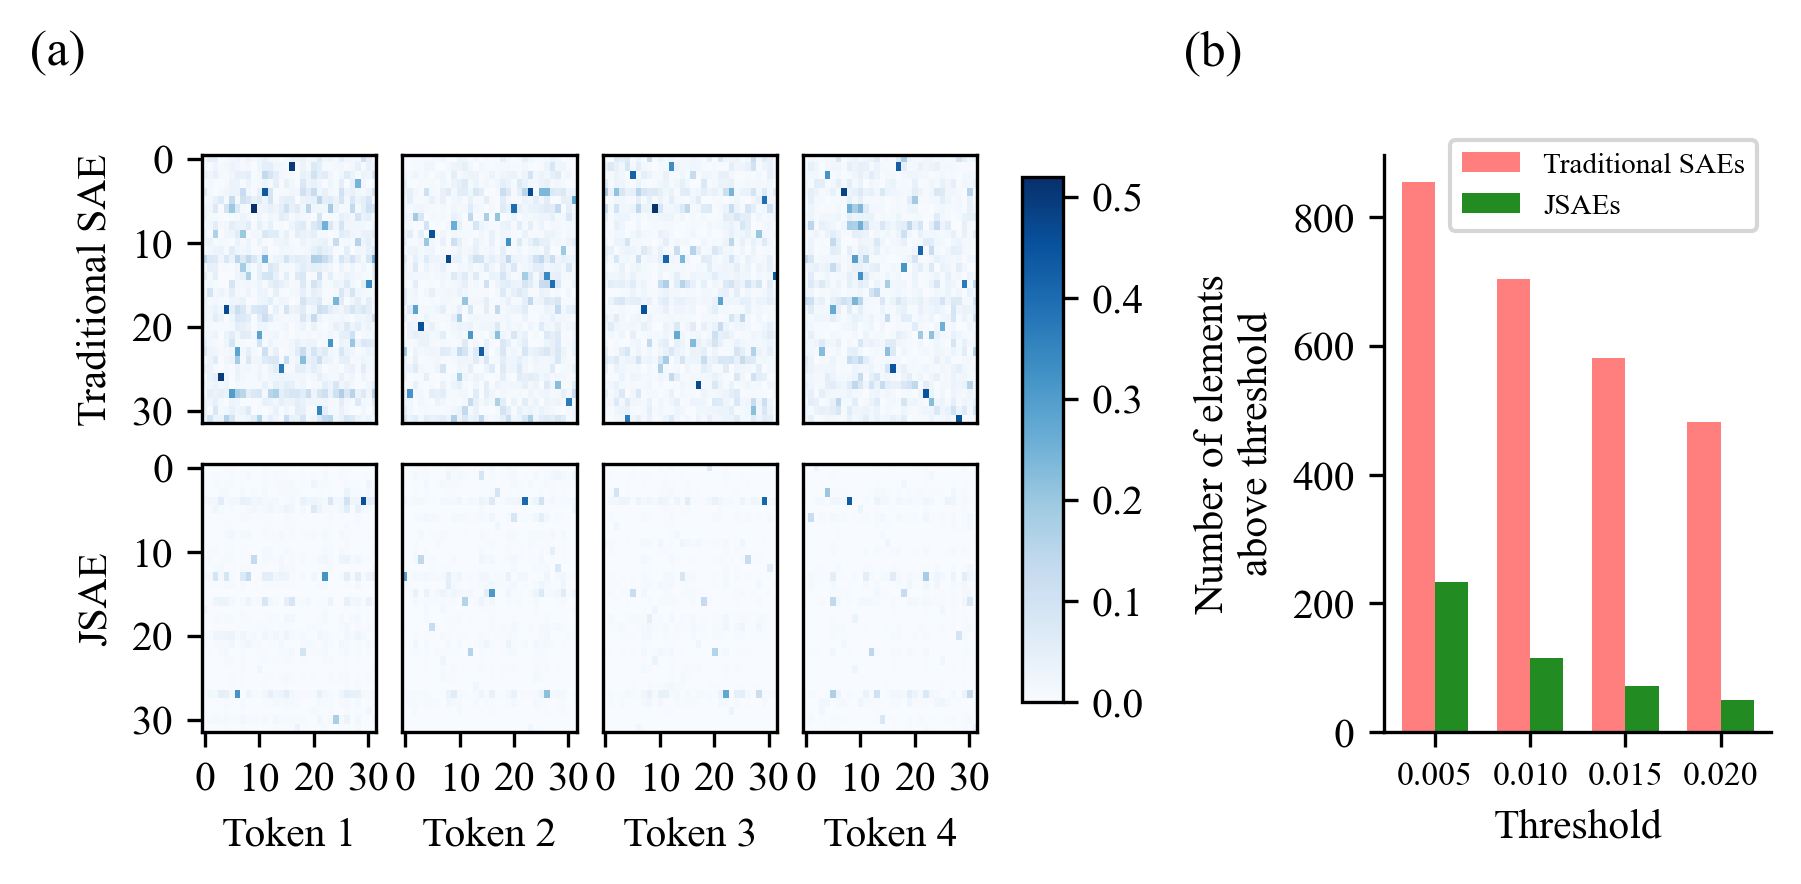

In [62]:
# Figure 1: Example Jacobians + Bar plot
fig1 = plt.figure(figsize=(6.75, 2.5), dpi=300)
gs1 = plt.GridSpec(1, 2, width_ratios=[2, 1], wspace=0.7)

# Left panel: Jacobian examples with no normalization
add_jacobian_panel(fig1, gs1, jacobian, jacobian_no_optim, position='left',
                   normalization=None, width_ratio=2)

# Right panel: Bar plot
ax1 = fig1.add_subplot(gs1[1])
bar_width = 0.35
bar_positions = np.arange(len(thresholds))
ax1.bar(bar_positions, num_above_thresholds_no_optim, bar_width, 
        label='Traditional SAEs', color='red', alpha=0.5)
ax1.bar(bar_positions + bar_width, num_above_thresholds, bar_width, 
        label='JSAEs', color='forestgreen')
ax1.set_xticks(bar_positions + bar_width / 2)
ax1.set_xticklabels([f"{t:.3f}" for t in thresholds], fontsize=8)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of elements\nabove threshold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 1.05), fancybox=True, fontsize=7)

plt.figtext(0.04, 1, '(a)', fontsize=12)
plt.figtext(0.61, 1, '(b)', fontsize=12)

plt.savefig('./charts/jac_sparsity.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


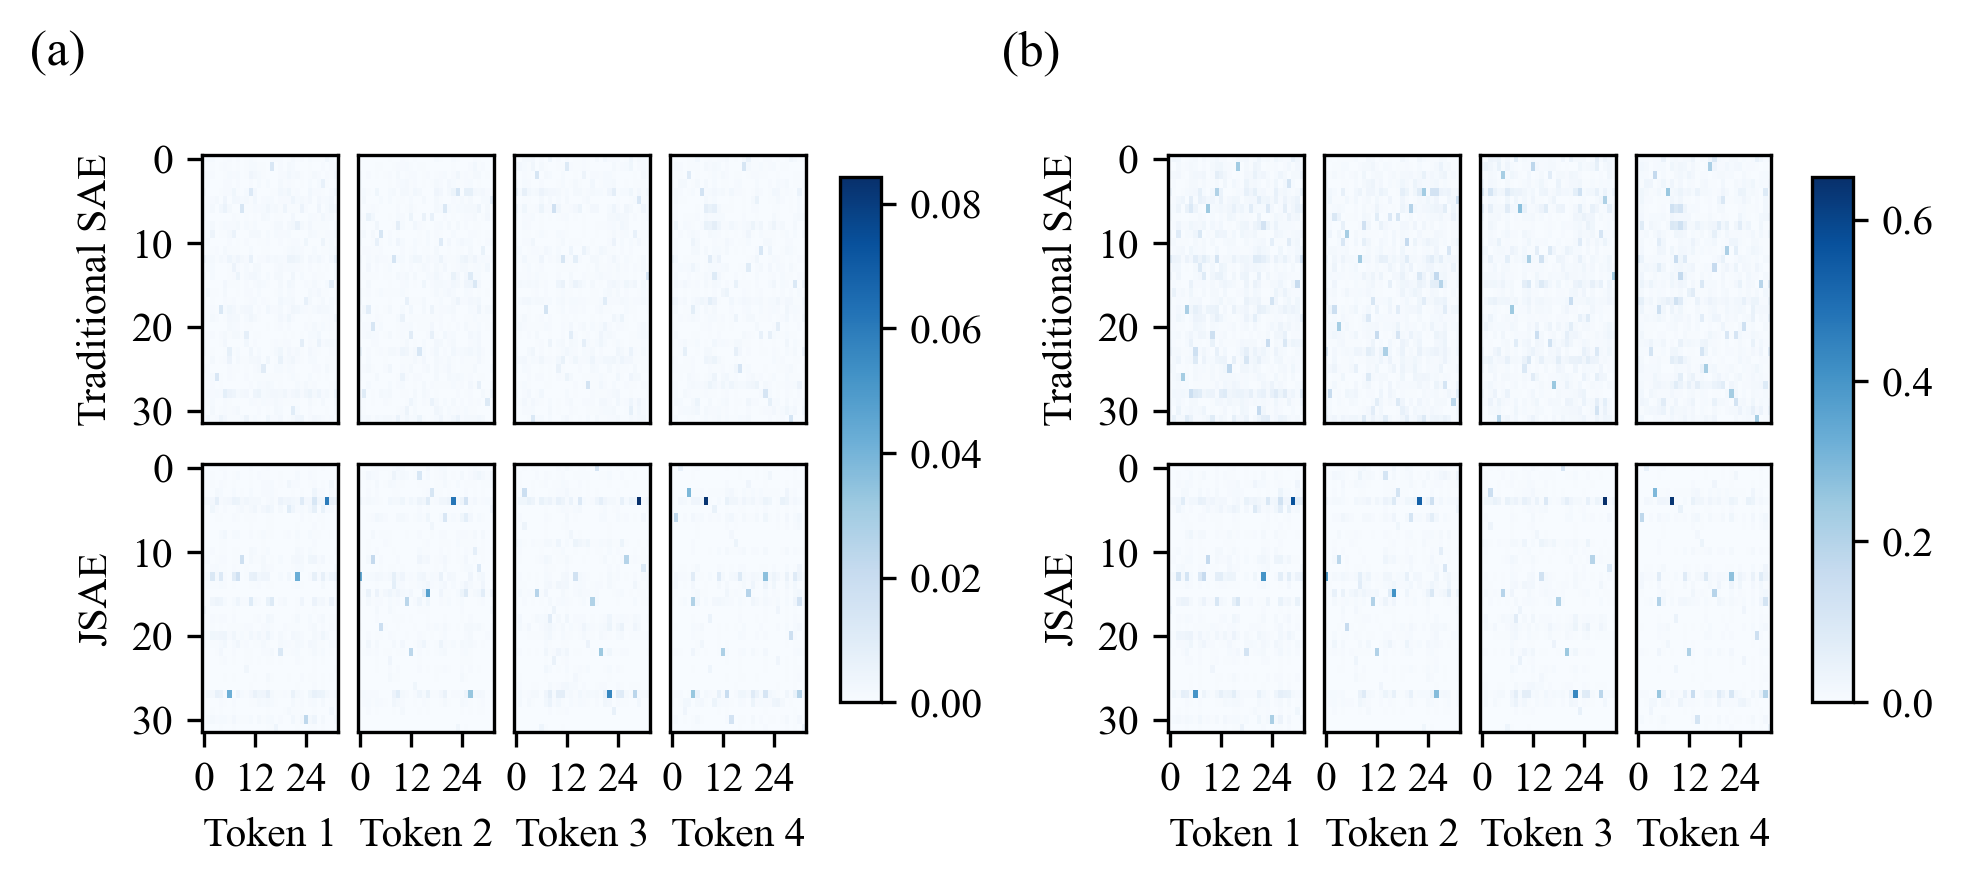

In [34]:
fig2 = plt.figure(figsize=(6.75, 2.5), dpi=300)
gs2 = plt.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.6)

# Left panel: L1 normalized Jacobians
add_jacobian_panel(fig2, gs2, jacobian, jacobian_no_optim, position='left', normalization="L1")

# Right panel: L2 normalized Jacobians
add_jacobian_panel(fig2, gs2, jacobian, jacobian_no_optim, position='right', normalization="L2")

plt.figtext(0.04, 1, '(a)', fontsize=12)
plt.figtext(0.52, 1, '(b)', fontsize=12)

plt.savefig('./charts/jac_examples_normed.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Random LLMs

In [37]:
model = "pythia-70m-deduped"
layer = 3

def get_randomized_hist_path(model: str, layer: int, trained_with_jac: bool, randomized: bool):
    path = f"../results/histograms/sae_pair_{model}"
    if randomized:
        path += "-randomized"
    path += f"_layer{layer}_16384_J{1 if trained_with_jac else 0}_k32:v0.safetensor"
    return path

histograms = {}
with safe_open(get_randomized_hist_path(model, layer, True, False), framework="pt") as f:
    histograms["J1"] = f.get_tensor("hist")
    bin_edges = f.get_tensor("bin_edges")
    n_tokens_in_hist = int(float(f.metadata()["tokens"]))

bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
histograms["J1-randomized"] = load_file(get_randomized_hist_path(model, layer, True, True))["hist"]
histograms["J0"] = load_file(get_randomized_hist_path(model, layer, False, False))["hist"]
histograms["J0-randomized"] = load_file(get_randomized_hist_path(model, layer, False, True))["hist"]

thresholds = [0.005, 0.01, 0.015, 0.02]
num_above_thresholds_in_hists = {key: [] for key in histograms.keys()}
for thresh in thresholds:
    # find the index of the bin edge that is equal to the threshold (assume it will always be there)
    idx = torch.where((bin_edges - thresh).abs() < 1e-6)[0].item()
    for key, hist in histograms.items():
        num_above_thresholds_in_hists[key].append(hist[idx:].sum().item() / n_tokens_in_hist)


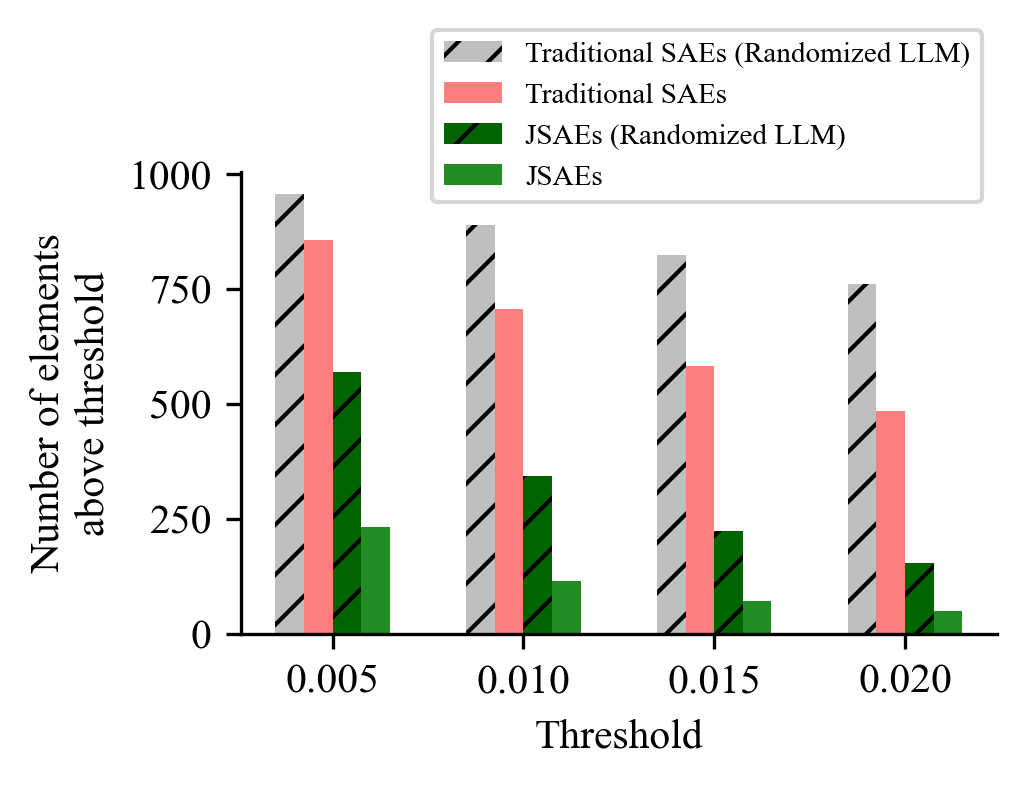

In [ ]:
fig = plt.figure(figsize=(3.25, 2), dpi=300)

# Bar plot with 4 bars
bar_width = 0.15
bar_positions = np.arange(len(thresholds))

plt.bar(bar_positions - bar_width, num_above_thresholds_in_hists['J0-randomized'], bar_width, 
        label='Traditional SAEs (Randomized LLM)', color='gray', alpha=0.5, hatch='//')
plt.bar(bar_positions, num_above_thresholds_in_hists['J0'], bar_width, 
        label='Traditional SAEs', color='red', alpha=0.5)
plt.bar(bar_positions + bar_width, num_above_thresholds_in_hists['J1-randomized'], bar_width, 
        label='JSAEs (Randomized LLM)', color='darkgreen', hatch='//')
plt.bar(bar_positions + 2*bar_width, num_above_thresholds_in_hists['J1'], bar_width, 
        label='JSAEs', color='forestgreen')

# Adjust x-axis to center the labels between all 4 bars
plt.xticks(bar_positions + bar_width/2, [f"{t:.3f}" for t in thresholds])
plt.xlabel('Threshold')
plt.ylabel('Number of elements\nabove threshold')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.34), fancybox=True, fontsize=7)
plt.savefig('./charts/randomized.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Causal independence

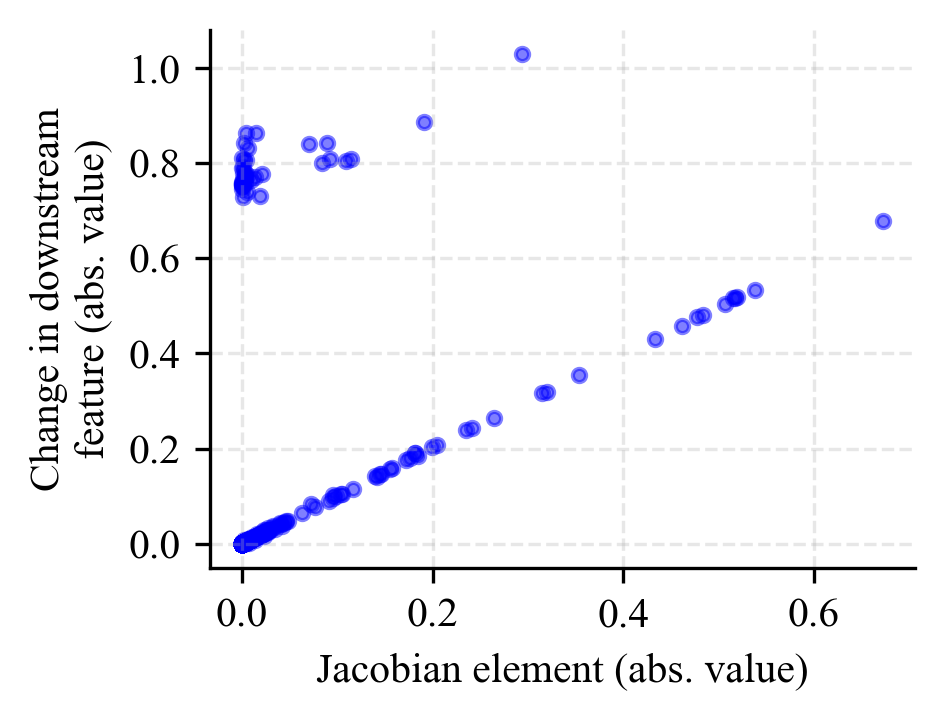

0.9749128818511963

In [26]:
take_abs = True
n_downsampled = 1_000

abl_data = load_file("../results/ablation/sae_pair_pythia-70m-deduped_layer3_16384_J1_k32:v0.safetensor")
abl_samples_full = abl_data["results"]

is_on_line = (abl_samples_full[:, 0] + abl_samples_full[:, 1]).abs() < 0.1

if take_abs:
    abl_samples_full.abs_()
    # abl_samples_no_optim.abs_()


abl_sample_small = abl_samples_full[torch.randint(0, abl_samples_full.shape[0], (n_downsampled,))]



plt.figure(figsize=(3.25, 2.5), dpi=300)

# Create scatter plot
plt.scatter(
    abl_sample_small[:, 0].cpu().numpy(),
    abl_sample_small[:, 1].cpu().numpy(),
    color='blue',
    alpha=0.5,  # Add some transparency
    s=10,  # Reduce marker size for paper
)

# Labels
plt.xlabel(f"Jacobian element{' (abs. value)' if take_abs else ''}")
plt.ylabel(f"Change in downstream\nfeature{' (abs. value)' if take_abs else ''}", multialignment='center')

# Style adjustments
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout and save
plt.tight_layout()
plt.savefig('./charts/abl_scatter.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()


is_on_line.float().mean().item()

In [27]:
is_on_line.shape

torch.Size([10000000])

chart ideas to explore this
- Laurence's idea: for each plot on this chart, sweep over the upstream feature values and plot how the downstream feature values change (so for each dot on this plot, make a line chart)


TODO: bar plot for how many examples are on the line vs in the cluster

TODO: chart where each dot is a training run where you change the jac coeff; x axis is reconstruction quality, y axis is sparsity (and also simialr stuff for autointerp et al)

TODO: figure showing that the reconstruction quality (and autointerp) doesn't suffer

# Sweeps

## Jacobian sweep

### CE loss score vs jac elements above 0.01

/var/folders/qq/jnrk7jy10mjbmfv5hyvrfl7m0000gq/T/ipykernel_23543/111646657.py:5: UserWarning: You're not fetching all of the runs.


  warnings.warn("You're not fetching all of the runs.\n\n")


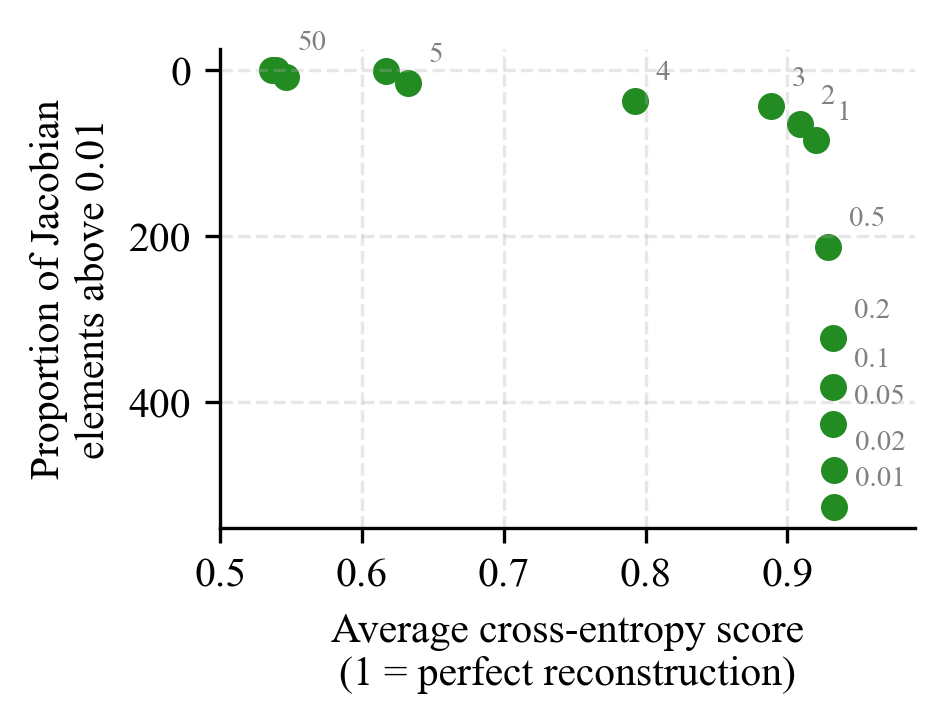

In [28]:
api = wandb.Api()
runs = api.runs("lucyfarnik/pythia70m-l3-sweep-j")

if runs.more:
    warnings.warn("You're not fetching all of the runs.\n\n")

metrics = ["jacobian_sparsity/jac_abs_above_0.01",
           "model_performance_preservation/ce_loss_score",
           "model_performance_preservation/ce_loss_score2"]

data = []
for run in runs:
    if run.state != "finished":
        warnings.warn(f"Run {run.id} is not finished.")
        continue
    run_data = {
        "jacobian_coefficient": run.config["jacobian_coefficient"],
    }
    for m in metrics:
        run_data[m.split("/")[-1]] = run.summary[m]
    data.append(run_data)

df = pd.DataFrame(data)
df["avd_ce_loss_score"] = (df["ce_loss_score"] + df["ce_loss_score2"]) / 2
# df["jac_coeff_with_label"] = df["jacobian_coefficient"].apply(lambda x: f"λ={x}")

plt.figure(figsize=(3.25, 2.5), dpi=300)

# Create scatter plot
plt.scatter(
    df["avd_ce_loss_score"],
    df["jac_abs_above_0.01"],
    color='forestgreen',
    s=30  # Marker size
)

# Add text annotations for specific values
annotate_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 50]
for _, row in df.iterrows():
    if row["jacobian_coefficient"] in annotate_values:
        jac_coef = row["jacobian_coefficient"]
        if jac_coef == int(jac_coef):
            jac_coef = int(jac_coef)

        plt.annotate(
            f'{jac_coef}',
            (row["avd_ce_loss_score"], row["jac_abs_above_0.01"]),
            xytext=(5, 5),  # Offset
            textcoords='offset points',
            fontsize=7,
            color='gray'
        )

# Customize axes
plt.xlim(0.5, 0.99)
plt.gca().invert_yaxis()  # Reverse y-axis

# Labels
plt.xlabel('Average cross-entropy score\n(1 = perfect reconstruction)', multialignment='center')
plt.ylabel('Proportion of Jacobian\nelements above 0.01', multialignment='center')

# Style adjustments
plt.grid(True, linestyle='--', alpha=0.3)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout and save
plt.tight_layout()
plt.savefig('./charts/tradeoff_reconst_jac.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()


TODO rewrite to instead get the data from the eval runner

TODO do a bunch of these for different metrics; the more charts per unit of effort the better

TODO big grid of charts where the charts in a given row always have the same y axis and plots in the same col always have the same x axis
- These should include L1 sparsity dividied by sqrt(L2) — if those don't look as good, we might need to train with that as the objective to demonstrate that we're not just making the Jacs smaller